In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import preprocessing
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

from collections import Counter
from string import punctuation, digits
from time import time

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


%matplotlib inline

## 1. 文本数据分析

In [2]:
# 统计训练集和测试集大小
newsgroups_train = fetch_20newsgroups(subset='train').data
newsgroups_test = fetch_20newsgroups(subset='test').data
print(len(newsgroups_train), len(newsgroups_test))

11314 7532


In [3]:
# 文本样本呈现
print(newsgroups_train[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [4]:
# 文本类别名称
fetch_20newsgroups(subset='all').target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
# 全集中 文本类别分布
targets_all = fetch_20newsgroups(subset='all').target
targets_counts = Counter(targets_all)
targets_counts

Counter({0: 799,
         1: 973,
         2: 985,
         3: 982,
         4: 963,
         5: 988,
         6: 975,
         7: 990,
         8: 996,
         9: 994,
         10: 999,
         11: 991,
         12: 984,
         13: 990,
         14: 987,
         15: 997,
         16: 910,
         17: 940,
         18: 775,
         19: 628})

{10: 999, 3: 982, 17: 940, 4: 963, 12: 984, 19: 628, 11: 991, 13: 990, 0: 799, 8: 996, 7: 990, 5: 988, 1: 973, 14: 987, 16: 910, 6: 975, 9: 994, 18: 775, 2: 985, 15: 997}


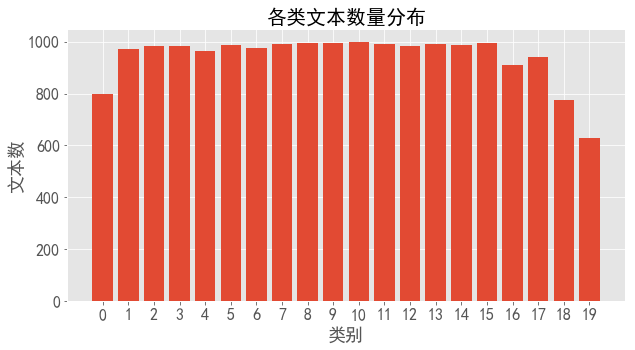

In [6]:
# 绘制全集文本类别分布柱状图
plt.style.use('ggplot')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

# Counter转为dict
plt.figure(figsize=(10,5))
x_y = {}
for x, y in targets_counts.items():
    x_y[x] = y
print(x_y)

plt.xticks(range(20), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('类别', fontsize=18)
plt.ylabel('文本数', fontsize=18)
plt.title('各类文本数量分布', fontsize=20)
plt.bar(x_y.keys(), x_y.values())
plt.show()

In [7]:
# 文本长度分布数据统计
newsgroups_all = fetch_20newsgroups(subset='all').data

all_texts_len = []
for text in newsgroups_all:
    # 去除文档中的标点和数字，并全部转换成小写
    text = ''.join([c for c in text.lower() if (c not in punctuation) and (c not in digits)])
    # 统计文本中的单词数目
    text = [word for word in text.split()]
    all_texts_len.append(len(text))

print(all_texts_len)

[156, 115, 561, 480, 140, 194, 58, 199, 143, 102, 115, 59, 1208, 97, 93, 172, 145, 258, 827, 330, 376, 199, 164, 247, 275, 62, 379, 70, 216, 501, 177, 90, 49, 125, 48, 76, 127, 144, 319, 142, 189, 84, 355, 74, 718, 141, 113, 44, 344, 85, 200, 194, 80, 28, 376, 254, 347, 328, 200, 429, 384, 566, 73, 472, 231, 159, 109, 138, 38, 228, 231, 112, 143, 148, 280, 471, 176, 277, 103, 191, 94, 102, 110, 104, 63, 100, 309, 692, 147, 358, 375, 283, 729, 99, 418, 310, 174, 173, 166, 144, 173, 64, 217, 128, 72, 252, 96, 378, 60, 72, 128, 322, 408, 195, 1166, 402, 108, 240, 236, 74, 233, 746, 242, 347, 140, 116, 29, 50, 119, 138, 143, 140, 164, 181, 165, 53, 300, 82, 158, 99, 531, 151, 260, 187, 303, 498, 86, 209, 76, 170, 81, 116, 316, 92, 160, 174, 143, 71, 196, 145, 116, 247, 56, 117, 139, 236, 67, 228, 225, 112, 219, 210, 81, 221, 18, 220, 369, 755, 72, 100, 93, 72, 582, 150, 117, 27, 80, 273, 225, 783, 101, 82, 217, 170, 250, 791, 266, 61, 114, 45, 46, 138, 308, 133, 43, 76, 24, 111, 184, 326, 

In [8]:
print(np.max(all_texts_len))
print(np.min(all_texts_len))

11573
10


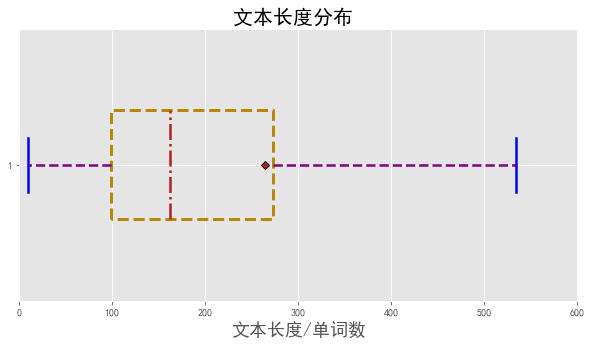

In [9]:
# 绘制文本长度分布图

boxprops = dict(linestyle='--', linewidth=3, color='darkgoldenrod')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick') #中位线的属性
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
capprops = dict(linewidth=2.5, color='blue') #箱线图顶端和末端线条属性
whiskerprops = dict(linestyle='--', linewidth=2.5, color='purple')


plt.figure(figsize=(10,5))

# all_texts_len_1000 = [x for x in all_texts_len if x < 1000]
# print(len(all_texts_len), len(all_texts_len_1000))
plt.xlabel('文本长度/单词数', fontsize=18)
# plt.ylabel('num of texts', fontsize=18)
plt.xlim(xmax=600)
plt.title('文本长度分布 ', fontsize=20)
plt.boxplot(all_texts_len, notch=False, vert=False, widths=0.4, showfliers=False, showmeans=True,
            boxprops = boxprops, capprops = capprops, whiskerprops = whiskerprops, 
            meanprops = meanpointprops, medianprops = medianprops)

plt.show()

In [10]:
# 长度大于1000个单词的文本数目

all_texts_len_1000 = [x for x in all_texts_len if x > 1000]
print(len(all_texts_len_1000))
print(all_texts_len_1000)

519
[1208, 1166, 1098, 2292, 1047, 1198, 1082, 2302, 2308, 1753, 1693, 1423, 7569, 1381, 4250, 1320, 1049, 1584, 1170, 1046, 1177, 1076, 1943, 2206, 1454, 1030, 1175, 1337, 1922, 1312, 1571, 8322, 1312, 1456, 1820, 1237, 1478, 1524, 1012, 1295, 1112, 1779, 3080, 8991, 1650, 1018, 1027, 1357, 1325, 1161, 1004, 3950, 1636, 1343, 1695, 2702, 4119, 2394, 1565, 1285, 1248, 1279, 1029, 1068, 1383, 2694, 1326, 7689, 1831, 1152, 1070, 1305, 1702, 3215, 1647, 1595, 9025, 8567, 2260, 3844, 1271, 1082, 1032, 1028, 1502, 1478, 1205, 1252, 6091, 7270, 1901, 5978, 1587, 3071, 1017, 2200, 1298, 6843, 3036, 1430, 1036, 1414, 2468, 3245, 4501, 1784, 5983, 1344, 1372, 1545, 3162, 2002, 5826, 2749, 1898, 1086, 7984, 1149, 1773, 1002, 1152, 2701, 1032, 1148, 1155, 1183, 6181, 6167, 1290, 8125, 1236, 1628, 1086, 1025, 4945, 1333, 3869, 1305, 3053, 1497, 2185, 1664, 1220, 1878, 1168, 1876, 1149, 2239, 7217, 2419, 1564, 1630, 4275, 1034, 4194, 3237, 1646, 2406, 1105, 1153, 2288, 7689, 1520, 1315, 1087, 1255,

In [11]:
# 单词数目少于15个单词的文本，应该是空样本
all_texts_15 = []
for text in newsgroups_all:
    text = ''.join([c for c in text.lower() if (c not in punctuation) and (c not in digits)])
    text = [word for word in text.split()]
    if len(text) < 15:
        all_texts_15.append(text)
        print(text)


['from', 'swdwannapieruwaterlooca', 'donald', 'wan', 'subject', 'just', 'testing', 'organization', 'university', 'of', 'waterloo', 'lines', 'hello', 'testing']
['from', 'skjievekaistackr', 'ji', 'soonki', 'subject', 'none', 'organization', 'the', 'internet', 'lines', 'subscribe', 'xpert', 'skjievekaistackr']
['from', 'davesgnptnuwcnavymil', 'dave', 'lewis', 'subject', 'unsubscribe', 'organization', 'the', 'internet', 'lines', 'to', 'xpertexpolcsmitedu', 'unsubscribe']
['from', 'mittlstafftcumnedu', 'subject', 'fast', 'modems', 'slow', 'macs', 'nntppostinghost', 'stafftcumnedu', 'organization', 'university', 'of', 'minnesota', 'lines']
['from', 'davesgnptnuwcnavymil', 'dave', 'lewis', 'subject', 'unsubscribe', 'organization', 'the', 'internet', 'lines', 'to', 'expertexpolcsmitedu', 'unsubscribe']
['from', 'grapesunednswsesnavymil', 'mike', 'grapevine', 'subject', 'subscribe', 'organization', 'the', 'internet', 'lines', 'to', 'expertexpolcsmitedu', 'subscribe', 'grapenswsesnavymil']
['fr

In [12]:
# 统计所有文本的单词数，不考虑错误的分词
words = []
for text in newsgroups_all:
    text = ''.join([c for c in text.lower() if (c not in punctuation) and (c not in digits)])
    words += [word for word in text.split()]

word_counts = Counter(words)

In [13]:
len(word_counts)

158055

In [14]:
# 按词频排序
words_list = sorted(word_counts, key=word_counts.get, reverse=True)[:20]
words_list

['the',
 'to',
 'of',
 'a',
 'and',
 'in',
 'is',
 'i',
 'that',
 'it',
 'for',
 'you',
 'from',
 'on',
 'this',
 'be',
 'not',
 'are',
 'have',
 'with']

In [15]:
word_counts['the']

240506

In [16]:
# 前20的词频分布数据
word_xy = {word: word_counts[word]/1000 for word in words_list}
word_xy

{'a': 101.126,
 'and': 94.986,
 'are': 29.969,
 'be': 30.746,
 'for': 46.412,
 'from': 37.198,
 'have': 29.962,
 'i': 69.387,
 'in': 80.337,
 'is': 70.061,
 'it': 48.29,
 'not': 30.324,
 'of': 113.84,
 'on': 33.028,
 'that': 62.564,
 'the': 240.506,
 'this': 32.733,
 'to': 120.304,
 'with': 28.624,
 'you': 41.114}

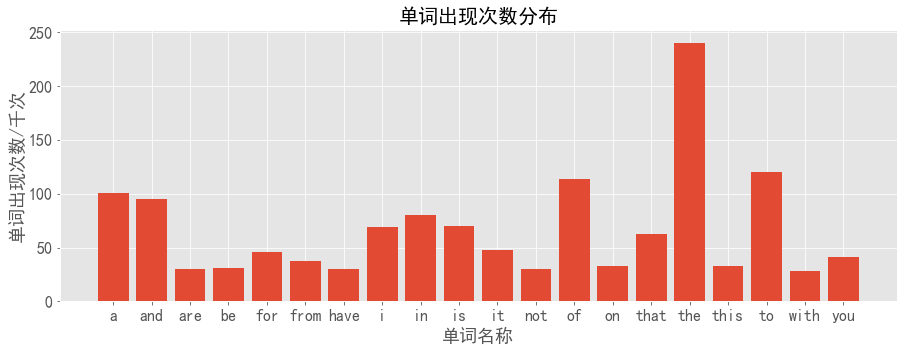

In [17]:
# 绘制前20的词频分布数据图
plt.figure(figsize=(15,5))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('单词名称', fontsize=18)
plt.ylabel('单词出现次数/千次', fontsize=18)
plt.title('单词出现次数分布', fontsize=20)
plt.bar(word_xy.keys(), word_xy.values())
plt.show()

## 2. 数据预处理

In [18]:
# 读取全集
newsgroups_all = fetch_20newsgroups(subset='all').data
print(type(newsgroups_all))
print(len(newsgroups_all))


<class 'list'>
18846


In [19]:
# 从NLTK中导入WordNetLemmatizer 对词进行还原： is - be； dogs - dog
wordnet_lemmatizer = WordNetLemmatizer()

wordnet_lemmatizer.lemmatize('passed', pos='v')

'pass'

In [20]:
# 统计全集词列表
words = []
for text in newsgroups_all:
    # 去除文档中的标点和数字，并全部转换成小写
    text = ''.join([c for c in text.lower() if (c not in punctuation) and (c not in digits)])
    # 将文档拆成单词，并进行词还原
    words += [wordnet_lemmatizer.lemmatize(word, pos='v') for word in text.split()]

print(len(words))

4990284


In [21]:
# 组成全集词汇表
counts = Counter(words)
counts.most_common()

[('the', 240506),
 ('be', 180873),
 ('to', 120304),
 ('of', 113840),
 ('a', 101126),
 ('and', 94986),
 ('in', 80337),
 ('i', 69387),
 ('that', 62564),
 ('have', 51823),
 ('it', 48290),
 ('for', 46412),
 ('you', 41114),
 ('from', 37198),
 ('on', 33028),
 ('this', 32733),
 ('not', 30324),
 ('do', 30108),
 ('with', 28624),
 ('as', 25734),
 ('or', 23745),
 ('if', 22495),
 ('but', 21821),
 ('line', 21475),
 ('subject', 20514),
 ('they', 20202),
 ('organization', 18628),
 ('by', 18168),
 ('at', 17902),
 ('write', 17259),
 ('an', 16233),
 ('can', 15887),
 ('my', 15796),
 ('what', 15622),
 ('will', 15226),
 ('all', 15021),
 ('would', 14781),
 ('there', 14535),
 ('use', 14496),
 ('one', 14052),
 ('about', 13756),
 ('re', 13468),
 ('get', 13371),
 ('we', 13029),
 ('he', 12368),
 ('so', 12315),
 ('your', 12283),
 ('no', 11972),
 ('article', 11877),
 ('say', 11797),
 ('any', 11543),
 ('me', 10990),
 ('know', 10980),
 ('some', 10908),
 ('who', 10603),
 ('its', 10172),
 ('which', 10170),
 ('out', 10

In [22]:
# 检查异常值 maxaxaxaxaxaxaxaxaxaxaxaxaxaxax
from sklearn .datasets import fetch_20newsgroups
from string import punctuation, digits

outliers = fetch_20newsgroups(subset='all').data

c = 0 # 计数

for text in outliers:
    outlier = ''.join([c for c in text.lower() if (c not in punctuation) and (c not in digits)])
    if 'maxaxax' in outlier:
        c += 1
        print(text)
    if c > 1:
        break

Subject: roman.bmp 09/14------------ Part 9 of 14 ------------
From: pwiseman@salmon.usd.edu (Cliff)
Reply-To: pwiseman@salmon.usd.edu (Cliff)
Distribution: usa
Organization: University of South Dakota
Lines: 958


MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>',3'$9F8+"Z5'1]_?W]_?WWIZ>BHJ*BHJ*BHJ*BHJ*GIZ
M>GIZ>GIZ*BHJ*GIZ>M_?1T>EI0L+"V9F9F9FR,A_?W_(5Z(46Q04%%=75VO4
MU-34U-34U`("`@("`@("`M34?W]_?]#084O#%%O`.#AUG@&$`0$Y.?518)0&
MC#`P8V-55555555559-65@HWGV`7]?7U%Q>?GY^?GP!@45$&*2G:VBDIGIZ'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'34T2P<'HP<$2$A+!P<'!P1(2$A)-34U-34TM,)11-];6UM;6
MUM8[(3N^AX>'AX>'AX>'AX>'AX?$9@NE1]]Z*BJ[`SW2&;!3[8LTQ<7%9V=G
M9V=G9V=G9V=G9V=GQ<4TBXN+B^WM4U.P&7'2TCT]F0.[>D<+9C&'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AVYAA`$DF&IJH*"NKJZ(B(B(W-P0N;:VMK:V
MMK:VN=R(KJ0M+2W:AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MS^K/S\]K:VLV-C;9V:D'E5E9E5G9V=G9V38V-C;``(*"O!,3O((``````"N5
M=A."*RDI]/2,!@:4-Y2,]"G:9&2L[,;OQO&D:@=Y

Subject: roman.bmp 11/14 
From: pwiseman@salmon.usd.edu (Cliff)
Reply-To: pwiseman@salmon.usd.edu (Cliff)
Distribution: usa
Organization: University of South Dakota
Lines: 956



------------ Part 11 of 14 ------------
MR1865%22DM75U=75U4)"0IV=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=
MG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=
MG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=
MG9V=0M75U=625!;)B8E,3`]G9S2+[>WM4QD]F0->7EXJWZ5F,8>'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX<Q9J5ZNP.9F3V9F9F9F3W2TG%Q&1FPL%-3[>WM[>WM[5-3L+!3L+`9
M&1D9&7%Q<7%Q<7%Q&7'2TCT]/=+2TM+2TM+2/3T]/3T]/=+2TG%QTCV9F0,#
M`P->7EZ[N[LJ>GIZW]]'1Z6EI0L+9F9F9F9F9F;$Q,3$Q,3$Q,3$9F8+"PL+
MI:5'>GHJ*BHJN[M>7EY>7@.9/3W2TG%Q<1D9L%-3[8N+-,5G9P],3$Q,3$Q,
M3$R)B8F)B8G)R<G)R<G)R<G)R186R<G)R<G)

In [23]:
# 从NLTK中引入停用词，从全集词汇表中删除
stoplist = stopwords.words('english')

# 从词汇表中删除计数少于10次，或者字母长度大于20的单词 like 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax'
vocab = {word: num for word, num in counts.items() if (word not in stoplist) and (num > 10) and (1 < len(word) < 20)}

# 按照计数排序
vocab_list = sorted(vocab, key=vocab.get, reverse=True)

In [24]:
len(vocab_list) # 词还原后， 词汇量从 22406 缩减到 17504

17504

In [25]:
# 将单词映射到数字，从1开始
vocab_to_int = {word: i for i ,word in enumerate(vocab_list, 1)}
print(vocab_to_int)

{'line': 1, 'subject': 2, 'organization': 3, 'write': 4, 'would': 5, 'use': 6, 'one': 7, 'get': 8, 'article': 9, 'say': 10, 'know': 11, 'think': 12, 'make': 13, 'like': 14, 'go': 15, 'dont': 16, 'people': 17, 'university': 18, 'nntppostinghost': 19, 'time': 20, 'see': 21, 'also': 22, 'work': 23, 'new': 24, 'im': 25, 'take': 26, 'want': 27, 'good': 28, 'could': 29, 'well': 30, 'right': 31, 'need': 32, 'us': 33, 'even': 34, 'come': 35, 'look': 36, 'may': 37, 'give': 38, 'find': 39, 'file': 40, 'way': 41, 'try': 42, 'much': 43, 'many': 44, 'state': 45, 'first': 46, 'two': 47, 'distribution': 48, 'question': 49, 'system': 50, 'run': 51, 'call': 52, 'god': 53, 'mean': 54, 'post': 55, 'program': 56, 'point': 57, 'anyone': 58, 'believe': 59, 'world': 60, 'drive': 61, 'seem': 62, 'tell': 63, 'read': 64, 'help': 65, 'really': 66, 'please': 67, 'number': 68, 'problem': 69, 'something': 70, 'back': 71, 'thank': 72, 'game': 73, 'since': 74, 'computer': 75, 'include': 76, 'still': 77, 'ive': 78, 'c

In [26]:
# 定义训练集和测试集的预处理函数
def pre_process_data(raw_data, seq_len=200):
    # 预处理数据特征
    # raw data: 如 newsgroups_train.data = fetch_20newsgroups(subset='train').data
    # seq_len: 文本序列长度
    
    # 将文档组成数字列表
    all_texts = []
    # length = []
    for text in raw_data:
        text = ''.join([c for c in text.lower() if c not in punctuation and c not in digits])
        text = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in text.split()]
        text = [vocab_to_int[word] for word in text if word in vocab_to_int]
        all_texts.append(text)
        # length.append(len(text))
    
    # 把数字列表转换成200列的矩阵，不足200的序列前面补0，超过的取前200个数字
    features = np.zeros((len(all_texts), seq_len), dtype=int)
    for i, row in enumerate(all_texts):
        features[i, -len(row):] = np.array(row)[:seq_len]
    return features


def pre_process_targets(raw_target, classes=20):
    # 预处理数据标签 独热编码
    lb = preprocessing.LabelBinarizer()
    lb.fit(list(range(classes)))
    return lb.transform(raw_target)

In [27]:
# 训练集特征
train_features = pre_process_data(fetch_20newsgroups(subset='train').data)
train_features[:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [28]:
# 训练集标签
train_target = pre_process_targets(fetch_20newsgroups(subset='train').target)

In [29]:
# 按照8:2的比例拆分训练集为训练集和验证集
train_val = int(len(train_features) * 0.8)
train_x, val_x = train_features[:train_val], train_features[train_val:]
train_y, val_y = train_target[:train_val], train_target[train_val:]
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(9051, 200)
(9051, 20)
(2263, 200)
(2263, 20)


In [30]:
# 获取测试集特征和标签
test_x = pre_process_data(fetch_20newsgroups(subset='test').data)
test_y = pre_process_targets(fetch_20newsgroups(subset='test').target)
print(test_x.shape)
print(test_y.shape)

(7532, 200)
(7532, 20)


## 3. RNN模型搭建

In [31]:
# RNN 超参数
embed_size = 128 # 词向量维度
seq_len = 200 # 序列长度
lstm_size = 128 # 隐藏层神经元
lstm_layers = 2 # 隐藏层层数
batch_size = 500 # 每批训练大小
learning_rate = 0.001
num_classes = 20 # 类别数
n_words = len(vocab_to_int) + 1 # 词汇表大小

In [32]:
# lstm核，并添加dropout层
def lstm_cell(lstm_size, keep_prob):
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size, state_is_tuple=True, reuse=tf.get_variable_scope().reuse)
    return tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

In [33]:
# 分批次训练
def get_batches(x, y, batch_size):
    n_batches = len(x) // batch_size

    for ii in range(0, n_batches * batch_size, batch_size):
        # 最后一个批次取余下的所有元素
        if ii != (n_batches - 1) * batch_size: 
            every_x, every_y = x[ii:ii+batch_size], y[ii:ii+batch_size]
        else:
            every_x, every_y = x[ii:], y[ii:]
        yield every_x, every_y

In [34]:
# RNN 模型
graph = tf.Graph()

with graph.as_default():
    # 输入数据
    inputs_ = tf.placeholder(tf.int32, shape=[None, None], name='inputs')
    labels_ = tf.placeholder(tf.float32, shape=[None, num_classes], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    # 词向量映射，word2vec嵌入层
    embedding = tf.get_variable('embedding', [n_words, embed_size] , initializer=tf.random_uniform_initializer(-1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

    # 多层RNN网络 - 2层
    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell(lstm_size, keep_prob) for _ in range(lstm_layers)], state_is_tuple=True)
    # initial_state = cell.zero_state(batch_size, tf.float32)

    outputs, _ = tf.nn.dynamic_rnn(cell, embed, initial_state=None, dtype=tf.float32)
    last = outputs[:, -1, :]

    # 全连接层
    fc = tf.layers.dense(last, lstm_size, name='fc')
    fc = tf.contrib.layers.dropout(fc, keep_prob=keep_prob)
    fc = tf.nn.relu(fc)
    
    # 分类器
    logits = tf.layers.dense(fc, num_classes, name='logits')
    predictions = tf.argmax(tf.nn.softmax(logits), 1) # 预测类别
    
    # 损失函数， 交叉熵, 正则化
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
    cost = tf.reduce_mean(cross_entropy)
    regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    total_cost = cost + 0.01 * sum(regularization_losses)
    
    # 优化器
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # 准确率
    correct_pred = tf.equal(tf.argmax(labels_, 1), predictions)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## 4. RNN模型训练

In [35]:
# 训练RNN 大约需要1小时
epochs = 40
# embed_size = 256 # 词向量维度
# lstm_size = 256 # 隐藏层神经元
n_batches = len(train_x) // batch_size
acc_dict = {}

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    t0 = time()
    for e in range(epochs):
        #state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1): 
            feed = {inputs_: x,
                    labels_: y,
                    keep_prob: 0.5}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss),
                      "Time: {}s".format(round(time() - t0, 1)))
                t0 = time()
    
            if ii == n_batches:
                train_acc = []
                
                for x, y in get_batches(train_x, train_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y,
                            keep_prob: 1}
                    batch_acc = sess.run(accuracy, feed_dict=feed)
                    train_acc.append(batch_acc)

                val_acc = []
                
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y,
                            keep_prob: 1}
                    batch_acc = sess.run(accuracy, feed_dict=feed)
                    val_acc.append(batch_acc)

                acc_dict[e+1] = np.mean(train_acc), np.mean(val_acc)

                print("Train acc: {:.3f}".format(np.mean(train_acc)))
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration += 1
    saver.save(sess, "checkpoints/sentiment.ckpt")

Epoch: 1/40 Iteration: 5 Train loss: 2.998 Time: 18.7s
Epoch: 1/40 Iteration: 10 Train loss: 2.989 Time: 18.6s
Epoch: 1/40 Iteration: 15 Train loss: 2.986 Time: 18.7s
Train acc: 0.139
Val acc: 0.123
Epoch: 2/40 Iteration: 20 Train loss: 2.970 Time: 47.4s
Epoch: 2/40 Iteration: 25 Train loss: 2.947 Time: 19.1s
Epoch: 2/40 Iteration: 30 Train loss: 2.916 Time: 19.4s
Epoch: 2/40 Iteration: 35 Train loss: 2.849 Time: 19.2s
Train acc: 0.172
Val acc: 0.149
Epoch: 3/40 Iteration: 40 Train loss: 2.745 Time: 50.7s
Epoch: 3/40 Iteration: 45 Train loss: 2.770 Time: 19.6s
Epoch: 3/40 Iteration: 50 Train loss: 2.627 Time: 19.4s
Train acc: 0.232
Val acc: 0.201
Epoch: 4/40 Iteration: 55 Train loss: 2.543 Time: 49.3s
Epoch: 4/40 Iteration: 60 Train loss: 2.485 Time: 19.2s
Epoch: 4/40 Iteration: 65 Train loss: 2.401 Time: 19.5s
Epoch: 4/40 Iteration: 70 Train loss: 2.296 Time: 19.7s
Train acc: 0.328
Val acc: 0.258
Epoch: 5/40 Iteration: 75 Train loss: 2.224 Time: 51.3s
Epoch: 5/40 Iteration: 80 Train l

Epoch: 35/40 Iteration: 625 Train loss: 0.211 Time: 22.0s
Epoch: 35/40 Iteration: 630 Train loss: 0.283 Time: 22.5s
Train acc: 0.946
Val acc: 0.686
Epoch: 36/40 Iteration: 635 Train loss: 0.189 Time: 54.0s
Epoch: 36/40 Iteration: 640 Train loss: 0.275 Time: 22.4s
Epoch: 36/40 Iteration: 645 Train loss: 0.195 Time: 21.8s
Train acc: 0.955
Val acc: 0.687
Epoch: 37/40 Iteration: 650 Train loss: 0.261 Time: 54.1s
Epoch: 37/40 Iteration: 655 Train loss: 0.217 Time: 21.7s
Epoch: 37/40 Iteration: 660 Train loss: 0.234 Time: 21.6s
Epoch: 37/40 Iteration: 665 Train loss: 0.236 Time: 21.8s
Train acc: 0.967
Val acc: 0.698
Epoch: 38/40 Iteration: 670 Train loss: 0.164 Time: 54.0s
Epoch: 38/40 Iteration: 675 Train loss: 0.138 Time: 21.8s
Epoch: 38/40 Iteration: 680 Train loss: 0.163 Time: 21.8s
Train acc: 0.972
Val acc: 0.703
Epoch: 39/40 Iteration: 685 Train loss: 0.148 Time: 55.6s
Epoch: 39/40 Iteration: 690 Train loss: 0.131 Time: 21.9s
Epoch: 39/40 Iteration: 695 Train loss: 0.145 Time: 22.0s
Ep

## 5. 模型测试

In [36]:
# 测试
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y,
                keep_prob: 1}
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\sentiment.ckpt
Test accuracy: 0.592


In [37]:
print(acc_dict)

{1: (0.13924925, 0.12309305), 2: (0.17235431, 0.14885256), 3: (0.23209721, 0.20087352), 4: (0.32780319, 0.25777328), 5: (0.38695139, 0.31508783), 6: (0.48087958, 0.38898754), 7: (0.52891469, 0.42524707), 8: (0.60869467, 0.4833191), 9: (0.6393593, 0.49126804), 10: (0.6594581, 0.51371694), 11: (0.72044384, 0.56163371), 12: (0.73891711, 0.56749541), 13: (0.73721957, 0.55292529), 14: (0.77601397, 0.57694429), 15: (0.77807361, 0.5834443), 16: (0.81886792, 0.60425687), 17: (0.83477539, 0.61572278), 18: (0.81920123, 0.5988251), 19: (0.79033494, 0.55623591), 20: (0.84493393, 0.61379099), 21: (0.87031662, 0.63872278), 22: (0.88431454, 0.64794827), 23: (0.90834343, 0.66477585), 24: (0.91281676, 0.66093117), 25: (0.90049362, 0.6594823), 26: (0.92318916, 0.67589712), 27: (0.91500801, 0.67222476), 28: (0.92103696, 0.68612248), 29: (0.93839902, 0.68182898), 30: (0.8989566, 0.65182698), 31: (0.93694633, 0.66465461), 32: (0.94912541, 0.69145024), 33: (0.9581852, 0.68013954), 34: (0.94823658, 0.6987437

In [41]:
x = np.arange(1, 41, dtype=int)
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

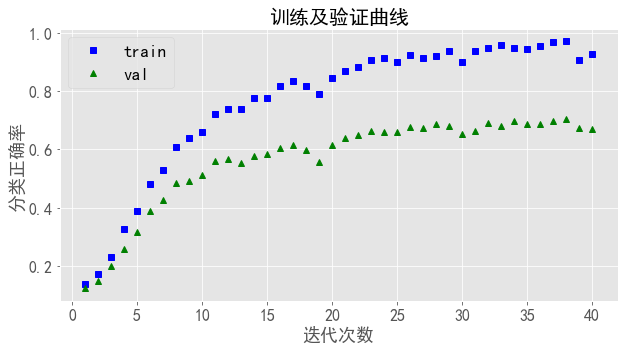

In [62]:
# 绘制训练曲线和验证曲线
plt.figure(figsize=(10,5))
y1_train = np.zeros(40)
y2_val = np.zeros(40)
for i in range(40):
    if i+1 == x[i]:
        y1_train[i] = acc_dict[i+1][0]
        y2_val[i] = acc_dict[i+1][1]



plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('迭代次数', fontsize=18)
plt.ylabel('分类正确率', fontsize=18)
plt.title('训练及验证曲线', fontsize=20)

plt.plot(x, y1_train, 'bs', x, y2_val, 'g^')
plt.legend(('train', 'val'), loc='upper left', fontsize='xx-large')

plt.show()